The following code creates a dataframe and loads a list of folders in the project column. Please download and extract the dataset yourself and adapt the paths if needed. 
https://github.com/lin-tan/llm-vul

In [74]:
import sys
print(sys.executable)


/Users/amadeo.valar/opt/anaconda3/envs/tensorflow/bin/python3


In [75]:
import numpy as np
import pandas as pd
import os
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

dataSource = "llm-vul-main/llm-vul-main/VJBench-trans"

df = pd.DataFrame()

df=pd.DataFrame(os.listdir(dataSource),columns=['project'])

In [76]:
df

,project
0,Quartz-1
1,VUL4J-18
2,VUL4J-20
3,Jenkins-3
4,VUL4J-74
5,VUL4J-73
6,VUL4J-10
7,Jenkins-2
8,VUL4J-26
9,VUL4J-19


This code adds the code of the original method. The dataset has additional files with partial transformations. Maybe, they are more useful for us, feel free to modify this.

In [77]:
df=pd.DataFrame(os.listdir(dataSource),columns=['project'])
df['original_method']=df.apply(lambda x: open(os.path.join(dataSource,x['project']+"/"+x['project']+"_original_method.java"),'r').read(), axis=1)

In [78]:
df

,project,original_method
0,Quartz-1,protected void initDocumentParser() throws Par...
1,VUL4J-18,public String getForwardPage( HttpServletReque...
2,VUL4J-20,public float[] toFloatArray()\n{\n float[] ...
3,Jenkins-3,@Override\n public SearchIndexBuilder m...
4,VUL4J-74,public SecureRandom getObject() throws Excepti...
5,VUL4J-73,"public boolean isPasswordValid(String encPass,..."
6,VUL4J-10,private void readObject(ObjectInputStream in)\...
7,Jenkins-2,"@Exported(name=""jobs"")\npublic List<TopLevelIt..."
8,VUL4J-26,public String getUrlRegex() {\n if (StringU...
9,VUL4J-19,@Override\npublic void prepareForDecryption(PD...


This adds the location of the bug in the original method. It is a list with 2 elements (start and end line); usually the same. 

In [79]:
import json
df['location_original_method']=df.apply(lambda x:json.load(open(os.path.join(dataSource,x['project']+"/"+"buggyline_location.json")))['original'],axis=1)

The InputFeatures class copied from the open source project

In [80]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 label):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.label=label

In [81]:
# # Use a pipeline as a high-level helper
# from transformers import pipeline
# 
# pipe = pipeline("feature-extraction")

Loading the model and tokeniser and move them to gpu if available. I have downloaded the model and this is a local path. Feel free to use the model id if it works for you. I am using codebert-base. 

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# tokenizer = RobertaTokenizer.from_pretrained("./model")
# model = RobertaModel.from_pretrained("./model")

# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

model.to(device)
def function_to_features(function, target_lines):
    return [line_to_features(line,line==4 ) for ind,line in enumerate(function.split('\n')) ] #todo properly set target line

The actual tokenization happens below. Maybe think about padding. Last week we discussed that we do not need to pad to the max line length

In [83]:
block_size=10#default from linevul paper
def line_to_features(line, target):
    code_tokens = tokenizer.tokenize(str(line))[:block_size-2]
    source_tokens = [tokenizer.cls_token] + code_tokens + [tokenizer.sep_token]
    source_ids = tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = block_size - len(source_ids)
    source_ids += [tokenizer.pad_token_id] * padding_length
    return InputFeatures(source_tokens, source_ids, target)

In [84]:
df

,project,original_method,location_original_method
0,Quartz-1,protected void initDocumentParser() throws Par...,"[[7, 7]]"
1,VUL4J-18,public String getForwardPage( HttpServletReque...,"[[3, 3]]"
2,VUL4J-20,public float[] toFloatArray()\n{\n float[] ...,"[[6, 6]]"
3,Jenkins-3,@Override\n public SearchIndexBuilder m...,"[[22, 22]]"
4,VUL4J-74,public SecureRandom getObject() throws Excepti...,"[[3, 9]]"
5,VUL4J-73,"public boolean isPasswordValid(String encPass,...","[[2, 2]]"
6,VUL4J-10,private void readObject(ObjectInputStream in)\...,"[[4, 4]]"
7,Jenkins-2,"@Exported(name=""jobs"")\npublic List<TopLevelIt...","[[3, 6]]"
8,VUL4J-26,public String getUrlRegex() {\n if (StringU...,"[[16, 16]]"
9,VUL4J-19,@Override\npublic void prepareForDecryption(PD...,"[[64, 64]]"


In [85]:
examples = []
def line_to_features(line, target):
    line=line.strip()#remove any whitespaces before or after the line
    code_tokens = tokenizer.tokenize(str(line))[:block_size-2]
    source_tokens = [tokenizer.cls_token] + code_tokens + [tokenizer.sep_token]
    padding_length = block_size - len(source_tokens)
    source_tokens += [tokenizer.pad_token] * padding_length
    source_ids = tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = block_size - len(source_ids)
    source_ids += [tokenizer.pad_token_id] * padding_length
    return InputFeatures(source_tokens, source_ids, target)


def function_to_features(function, target_lines):
    #return [line_to_features(line,True ) for ind,line in enumerate(function.split('\n')) if line.strip()!='' ] 
    return [line_to_features(line,target_lines[0][0]>=ind and target_lines[0][1]<=ind ) for ind,line in enumerate(function.split('\n')) if line.strip()!='' ] 
#examples=df.apply(lambda x:examples.append (function_to_features(x['original_method'],x['location_original_method'])), axis=1)#actually run anything

df['input_features']=df.apply(lambda function: function_to_features(function['original_method'],function['location_original_method']), axis=1)

Add the aggregation functions

In [86]:
import numpy as np

# Sum aggregation
def aggregate_sum(vectors):
    return np.sum(vectors, axis=0)

# Average aggregation
def aggregate_average(vectors):
    return np.mean(vectors, axis=0)

# Max aggregation
def aggregate_max(vectors):
    return np.max(vectors, axis=0)

# Min aggregation
def aggregate_min(vectors):
    return np.min(vectors, axis=0)

# Concatenation aggregation
def aggregate_concatenation(vectors):
    return np.concatenate(vectors, axis=0)

In [87]:
def function_to_features(function, target_lines):
    line_features = [line_to_features(line,target_lines[0][0]>=ind and target_lines[0][1]<=ind ) for ind,line in enumerate(function.split('\n')) if line.strip()!='' ]
    vectors = [feature.input_ids for feature in line_features]
    aggregated_vector = aggregate_sum(vectors)
    return InputFeatures(aggregated_vector, aggregated_vector, any(feature.label for feature in line_features))

In [88]:
updateDf=pd.DataFrame(os.listdir(dataSource),columns=['project'])
updateDf['input_features']=df.apply(lambda function: function_to_features(function['original_method'],function['location_original_method']), axis=1)

In [89]:
updateDf

,project,input_features
0,Quartz-1,<__main__.InputFeatures object at 0x1374c1210>
1,VUL4J-18,<__main__.InputFeatures object at 0x15f4cb8b0>
2,VUL4J-20,<__main__.InputFeatures object at 0x15f4b1ae0>
3,Jenkins-3,<__main__.InputFeatures object at 0x15f4b1f00>
4,VUL4J-74,<__main__.InputFeatures object at 0x15f4b1db0>
5,VUL4J-73,<__main__.InputFeatures object at 0x15f4b1ab0>
6,VUL4J-10,<__main__.InputFeatures object at 0x15d4b7dc0>
7,Jenkins-2,<__main__.InputFeatures object at 0x15f2a7e20>
8,VUL4J-26,<__main__.InputFeatures object at 0x15f2a7eb0>
9,VUL4J-19,<__main__.InputFeatures object at 0x15f2a7bb0>


In [90]:
examples=[item for row in df['input_features'] for item in row]

In [91]:
examplesUpdated = [row for row in df['input_features']]

In [92]:
examplesUpdated

[[<__main__.InputFeatures at 0x15d4b4fd0>,

The following can be used for train/test split

In [93]:
# We have to use embeddings to reduce the vocabulary -> to summarize the indvidual statements
examples

# Test the balance of the dataset

from collections import Counter

# Extract labels from examples
labels = [example.label for example in examples]

# Count the number of instances for each label
label_counts = Counter(labels)

# Print the counts
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: False, Count: 1351
Label: True, Count: 34


In [94]:
# try to solve the imbalance by oversampling
from imblearn.over_sampling import SMOTE

# Separate input features and target
X = [example.input_ids for example in examples]
y = [example.label for example in examples]

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

### Now X_res and y_res are the resampled features and labels, respectively



In [95]:
# Convert the resampled features into a DataFrame
features_df = pd.DataFrame(X_res)

# Convert the resampled labels into a DataFrame
labels_df = pd.DataFrame(y_res, columns=['label'])

# Concatenate the features and labels DataFrames
resampled_df = pd.concat([features_df, labels_df], axis=1)

# Now resampled_df is a DataFrame with the resampled features and labels

In [96]:
# Display the first few rows of the resampled DataFrame
resampled_df.head()

,0,1,2,3,4,5,6,7,8,9,label
0,0,37659,13842,45511,47088,49707,43048,6989,31443,2,False
1,0,47088,45200,47249,22053,45200,47249,5457,27246,2,False
2,0,37447,45200,47249,4,8738,47995,18851,250,2,False
3,0,37447,45200,47249,4,8738,48911,1295,1640,2,False
4,0,37447,45200,47249,4,8738,49385,46469,8166,2,False


In [97]:
# balance of the lables
resampled_df['label'].value_counts()

False    1351
True     1351
Name: label, dtype: int64

In [98]:
examples[1].input_tokens

['<s>',
 'Document',
 'Builder',
 'Factory',
 'Ġdoc',
 'Builder',
 'Factory',
 'Ġ=',
 'ĠDocument',
 '</s>']

In [99]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(examples, test_size=0.1, random_state=42)
trainUpdated, testUpdated = train_test_split(examplesUpdated, test_size=0.1, random_state=42)

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline(
    steps=[
        #("scaler", StandardScaler()),
        #("knn", KNeighborsClassifier(n_neighbors=11))]
        ("rfc",     RandomForestClassifier(
            max_depth=5, n_estimators=10, max_features=1, random_state=42
        ))]
)


In [101]:
pipe

Pipeline(steps=[('rfc',
                 RandomForestClassifier(max_depth=5, max_features=1,
                                        n_estimators=10, random_state=42))])

In [105]:
train_x=list(map(lambda line:line.input_ids,train))
train_y=list(map(lambda line:line.label,train))

In [108]:
trainUpdated[0].input_ids
# train_x_updated=list(map(lambda line:line.input_ids,trainUpdated))
# train_y_updated=list(map(lambda line:line.label,trainUpdated))

AttributeError: 'list' object has no attribute 'input_ids'

In [ ]:
train_x_updated


In [ ]:
train_y

In [112]:
pipe.fit(train_x, train_y)

Pipeline(steps=[('rfc',
                 RandomForestClassifier(max_depth=5, max_features=1,
                                        n_estimators=10, random_state=42))])

In [ ]:
pipe.fit(train_x_updated, train_y_updated)

In [ ]:
len(train_x[0])

In [ ]:
len(train_x[1])

In [ ]:
test_x=list(map(lambda line:line.input_ids,test))
test_y=list(map(lambda line:line.label,test))

In [ ]:
test_x_updated=list(map(lambda line:line.input_ids,testUpdated))
test_y_updated=list(map(lambda line:line.label,testUpdated))

In [ ]:
test_x_updated

In [113]:
r=pipe.predict(train_x)
r

array([False, False, False, ..., False, False, False])

In [114]:
def count_values(arr):
    unique_values, counts = np.unique(arr, return_counts=True)
    value_counts = dict(zip(unique_values, counts))
    return value_counts

In [115]:
count_values(train_y_updated)

{False: 15, True: 30}

In [116]:
count_values(test_y_updated)

{False: 1, True: 4}

In [117]:
unique_values, counts = np.unique(r, return_counts=True)

In [118]:
# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: False, Count: 1245
Value: True, Count: 1


In [119]:
test_y_updated




[True, True, True, False, True]

### Evaluate the Model with the AUC Score

The AUC (Area Under the Curve) is a metric used to evaluate the performance of binary classification models. It measures the area under the Receiver Operating Characteristic (ROC) curve, which plots the true positive rate against the false positive rate at various classification thresholds. A higher AUC indicates that the model has better overall performance in distinguishing between the two classes. Generally, an AUC score above 0.5 indicates a model better than random guessing, with scores between 0.7 and 0.8 considered good, and scores above 0.9 considered excellent.

In [120]:
from sklearn.metrics import roc_auc_score

# Predict the probabilities of the positive class
train_y_prob = pipe.predict_proba(train_x)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(train_y, train_y_prob)

print(f"AUC Score: {auc_score}")

AUC Score: 0.8970334060578584


Plotting the ROC curve

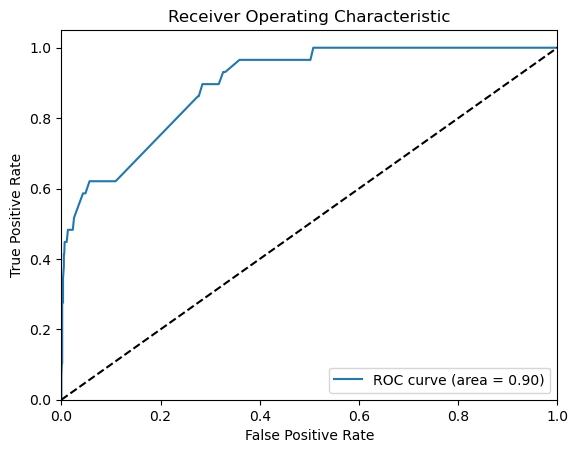

In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(train_y, train_y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()